<a href="https://colab.research.google.com/github/tamirmal/tau_dl_proj/blob/master/Adaptive_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arguments

In [0]:
# Train or Evaluate
_MODE = 'train' #@param ['train', 'eval', 'resume_train']
# Load models if resuming training or evaluating existing model
_resume_train_from = 'final_iter_79999.pth' #@param {type: "string"}
_eval_model_path = 'split_1_final_iters_40000.pth' #@param {type: "string"}
# Where dataset is located, its name
_dataset_backend = 'gdrive'  #@param ['dropbox', 'gdrive', 'gbucket']
_style_dataset_name = 'wikiart_1.zip' #@param ['wikiart_1.zip', 'wikiart_2.zip', 'wikiart_3.zip', 'wikiart_4.zip']
_content_dataset_name = 'train2014_coco_1.zip' #@param ['train2014_coco_1.zip', 'train2014_coco_2.zip', 'train2014_coco_3.zip', 'train2014_coco_4.zip']
# Optimizer settings
_optimizer = 'adam' #@param ['adam', 'SGD']
_lr_decay = 0 #@param {type:"number"}

# Implementation

In [2]:
#!pip install ipdb
#import ipdb
!pip install piexif


import datetime, os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

GLOBAL_ARGS = {}
GLOBAL_ARGS['dataset_backend'] = _dataset_backend
GLOBAL_ARGS['lr'] = 5e-5
GLOBAL_ARGS['lr_decay'] = _lr_decay
GLOBAL_ARGS['momentum'] = 0.9
GLOBAL_ARGS['optimizer'] = _optimizer
GLOBAL_ARGS['batch_size'] = 8
GLOBAL_ARGS['max_iters'] = 160000
GLOBAL_ARGS['max_iters_per_split'] = GLOBAL_ARGS['max_iters'] // 4
GLOBAL_ARGS['loss_style_w'] = 10 # Weight of style loss
GLOBAL_ARGS['loss_content_w'] = 1 # Weight of content loss
GLOBAL_ARGS['MODE'] = _MODE
GLOBAL_ARGS['resume_train_from'] = _resume_train_from
GLOBAL_ARGS['eval_model_path'] = _eval_model_path
GLOBAL_ARGS['style_dataset_name'] = _style_dataset_name
GLOBAL_ARGS['content_dataset_name'] = _content_dataset_name

"""
TAMIR:arguments from authors LUA code that are not used in my code :
-- Training options
cmd:option('-resume', false, 'If true, resume training from the last checkpoint')
cmd:option('-weightDecay', 0, 'Weight decay')
cmd:option('-targetContentLayer', 'relu4_1', 'Target content layer used to compute the loss')
cmd:option('-targetStyleLayers', 'relu1_1,relu2_1,relu3_1,relu4_1', 'Target style layers used to compute the loss')
cmd:option('-tvWeight', 0, 'Weight of TV loss')
cmd:option('-reconStyle', false, 'If true, the decoder is also trained to reconstruct style images')
cmd:option('-normalize', false, 'If true, gradients at the loss function are normalized')
"""

# check mode is valid
assert GLOBAL_ARGS['MODE'] in ['train', 'eval', 'resume_train']
#### Mount Google Drive
from google.colab import drive
if GLOBAL_ARGS['dataset_backend'] == 'gdrive' or GLOBAL_ARGS['dataset_backend'] == 'dropbox':
  drive.mount('/gdrive')
  model_save_path = '/gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models/'

#### Mount GCP bucket
from google.colab import auth
if GLOBAL_ARGS['dataset_backend'] == 'gbucket':
  auth.authenticate_user()
  project_id = 'tau-dl'
  !gcloud config set project {project_id}
  !gsutil ls
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
  !apt -qq update
  !apt -qq install gcsfuse
  !mkdir -p /content/adaptive_style_transfer/
  !gcsfuse --implicit-dirs adaptive_style_transfer /content/adaptive_style_transfer/

# For tensorboard use TF 2.x+
%tensorflow_version 2.x
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  cpu = torch.device("cpu")
else:
  # no GPU available
  assert 0

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
TensorFlow 2.x selected.


# Dataset preparation - download or list, define dataloaders

In [3]:
##### manual calculation of entire dataset length
## Number of content examples:
## 82783 /root/content_examples_paths.lst
## Number of style examples:
## 79433 /root/style_examples_paths.lst
##
## gbucket mode - images are stored on a GCP bucket (http access), we cant do 'ls' to get the file list
##                so I've manually creates a list by mounting the GCP bucket as a file-system and used 'gsutil ls'
##                The list is stored in the GCP bucket with the images
## gdrive  mode - dataset is split to 4 parts in ZIP files, files are copied from gdrive and unzipped locally
##


# Function that takes a path to a dataset file, path to extract the dataset into
# copies it to local storage
# unzip
# removes the .zip archive from local storage
def copy_and_unzip_dataset(F, D):
      if os.path.isdir(D):
        print("found {} directory, skipping".format(D))
        return

      if os.path.isfile(F) == False:
        print("copying {}".format(F))
        !date
#        !cp "/gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/$DATASET_FILE" ./
        !rsync --progress "/gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/$DATASET_FILE" ./
        !date
      else:
        print("{} already exists locally".format(F))

      # unzipping
      print("unzipping {} to {}".format(F, D))
      !date
      !7z e ${DATASET_FILE} -o${DATASET_DIR}
      !date
      print("done unzipping, removing zip archive")
      !rm -fr ${DATASET_FILE}
# End


def download_and_unzip_dataset(F, D):
      if 'wikiart' in F:
        url = 'https://dl.dropbox.com/s/uu1g98dsq5mw3x2/' + GLOBAL_ARGS['style_dataset_name'] +'?dl=1'
      elif 'coco' in F:
        url = 'https://dl.dropbox.com/s/nh8lxx3nnex1a1y/' + GLOBAL_ARGS['content_dataset_name'] +'?dl=1'

      if os.path.isdir(D):
        print("found {} directory, skipping".format(D))
        return

      if os.path.isfile(F) == False:
        print("downloading {}".format(F))
        !date
        os.environ['URL'] = url
        !wget -O ${DATASET_FILE} ${URL}
        !date
      else:
        print("{} already exists locally".format(F))

      # unzipping
      print("unzipping {} to {}".format(F, D))
      !date
      !7z e ${DATASET_FILE} -o${DATASET_DIR}
      !date
      print("done unzipping, removing zip archive")
      !rm -fr ${DATASET_FILE}
# End


if GLOBAL_ARGS['dataset_backend'] == 'gbucket':
  ##### Generate the file list for dataloaders
  #!gsutil ls gs://adaptive_style_transfer/COCO_SPLITS/*/*.jpg > /content/adaptive_style_transfer/content_examples_paths.lst
  #!gsutil ls gs://adaptive_style_transfer/WIKIART_SPLITS/*/*.jpg > /content/adaptive_style_transfer/style_examples_paths.lst

  !gsutil cp gs://adaptive_style_transfer/content_examples_paths.lst /root/
  !echo "Number of content examples:"
  !wc -l /root/content_examples_paths.lst

  !gsutil cp gs://adaptive_style_transfer/style_examples_paths.lst /root/
  !echo "Number of style examples:"
  !wc -l /root/style_examples_paths.lst
elif GLOBAL_ARGS['dataset_backend'] == 'gdrive' or GLOBAL_ARGS['dataset_backend'] == 'dropbox':
  import os
  wikiart_file = './' + GLOBAL_ARGS['style_dataset_name']
  mscoco_file = './' + GLOBAL_ARGS['content_dataset_name']

  for FILE in [wikiart_file, mscoco_file]:
    # set dataset folder, content or style ?
    if 'wikiart' in FILE:
      D = './dataset_style'
      O = '/root/style_examples_paths.lst'
    elif 'coco' in FILE:
      D = './dataset_content'
      O = '/root/content_examples_paths.lst'
    # export env vars
    os.environ['DATASET_FILE'] = FILE
    os.environ['DATASET_DIR'] = D
    os.environ['DATASET_LST'] = O
    # copy, extract and remove archive
    if GLOBAL_ARGS['dataset_backend'] == 'gdrive':
      copy_and_unzip_dataset(FILE, D)
    else:
      download_and_unzip_dataset(FILE, D)
    # Now list the files
    !find ${DATASET_DIR} -name "*.jpg" > ${DATASET_LST}
    !echo "number of examples in this split:"
    !wc -l ${DATASET_LST}
else:
  assert 0

found ./dataset_style directory, skipping
number of examples in this split:
19791 /root/style_examples_paths.lst
found ./dataset_content directory, skipping
number of examples in this split:
20695 /root/content_examples_paths.lst


In [0]:
from torch.utils import data
from PIL import Image, ImageFile
import requests
from io import BytesIO
from google.cloud import storage
import piexif

ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 1000000000                                                                                              

class DatasetFolders(data.Dataset):
    def __init__(self, files_paths, transform):
        super(DatasetFolders, self).__init__()
        with open(files_paths) as F:
          paths = F.readlines()
        self.paths = [x.strip() for x in paths] 
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]

        if GLOBAL_ARGS['dataset_backend'] == 'gbucket':
          # GCS backend
          # PROBLEM - because the dataloaders are multi-threaded but GCP client/buckets library is not thread-safe
          # I'm doing this
          #    client = ...
          #    bucket = ...
          # per-image 
          # so we need to create an instance per-thread.
          # adding this to the TODO list ...
          client = storage.Client(project=project_id)
          bucket = client.get_bucket('adaptive_style_transfer')
          blob_path = path.split('adaptive_style_transfer')[-1]
          blob_path = blob_path[1:] # first char is '/', trim it ...
          blob = bucket.get_blob(blob_path).download_as_string()
          bytes = BytesIO(blob)
          img = Image.open(bytes).convert('RGB')
        else:
          try:
            piexif.remove(path)
          except Exception:
            pass
          img = Image.open(path).convert('RGB')
        # End

        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'DatasetFolders'


trans = [
    transforms.Resize(size=(512, 512)),
    transforms.RandomCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
trans = transforms.Compose(trans)

content_dataset = DatasetFolders('/root/content_examples_paths.lst', trans)
style_dataset = DatasetFolders('/root/style_examples_paths.lst', trans)

# denorm (defined here to be close to the norm transformation)
def denorm(x):
    mu = torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1).to(device)
    sigma = torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1).to(device)
    return torch.clamp(x * sigma + mu, 0, 1)
# End

In [0]:
sd = 999
def torch_seed():
    global sd
    torch.manual_seed(sd)
    if torch.cuda.is_available():
      torch.cuda.manual_seed_all(sd)

## Training will not be in epochs but in iterations
## the dataloaders will need to be infinite
## (in epoch we finish an epoch at end of iteration)
## (doing as in the article/lua-torch code. training for 160,000 iteration with batch size of 8)

# the built in samplers in pytorch are not infinite, defining my own
def InfiniteSampler(dataset_len):
    torch_seed()
    perm_iter = iter(torch.randperm(dataset_len).tolist())
    while True:
      try:
        yield perm_iter.__next__()
      except StopIteration:
        perm_iter = iter(torch.randperm(dataset_len).tolist())
        yield perm_iter.__next__()

class InfiniteSamplerWrapper(data.sampler.Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31

def make_content_iter(batch_size=8, num_workers=8):
  return iter(data.DataLoader(
      content_dataset, batch_size=batch_size,
      sampler=InfiniteSamplerWrapper(content_dataset),
      num_workers=num_workers))
# End

def make_style_iter(batch_size=8, num_workers=8):
  return iter(data.DataLoader(
      style_dataset, batch_size=batch_size,
      sampler=InfiniteSamplerWrapper(style_dataset),
      num_workers=num_workers))

########################################
### Unit test
########################################
run = False
if run == True:
  content_iter = make_content_iter(1, 1)
  images = content_iter.next()
  print('images shape on batch size = {}'.format(images.size()))
  grid = torchvision.utils.make_grid(images)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  print(images[0])

# Network Implementation


![adain_net](https://i.imgur.com/jAyz9hY.jpg)

Implementing https://arxiv.org/pdf/1703.06868.pdf
There is an official reference in Torch / Lua @ https://github.com/xunhuang1995/AdaIN-style/



---


AdaIN Layer implements the following :

![adain_layer](https://i.imgur.com/OiqyfkN.png)



In [0]:
import torch.nn.functional as F

def get_mu_and_sigma(features):
    # input is a tensor of shape : [minibatch_size, channels, h ,w]
    # output is a tensor of shape : [minibatch_size, channels, 1 ,1]

    epsilon = 1e-6
    minibatch_size, channels = features.size()[:2]

    features_channels_stacked = features.reshape(minibatch_size, channels, -1)

    features_mean_per_channel = features_channels_stacked.mean(dim=2) # dim 0 : minibatch, dim 1 : channels, !! dim 2 : features col stack !!
    features_mean_per_channel = features_mean_per_channel.reshape(minibatch_size, channels, 1, 1) # set dim as tensor

    features_sigma_per_channel = features_channels_stacked.std(dim=2)
    features_sigma_per_channel = features_sigma_per_channel.reshape(minibatch_size, channels, 1, 1) # set dim as tensor
    # Notice! since we will do normalization (divide by sigma) - we add a small epsilon for numerical stablity (avoid NaN's or Inf's)
    return features_mean_per_channel, features_sigma_per_channel + epsilon

class vgg19_encoder(nn.Module):
      def __init__(self):
          super(vgg19_encoder, self).__init__()
          
          encoder = torchvision.models.vgg19(pretrained=True, progress=True)
          print(encoder) # print encoder, to make sure i'm extracting the correct layers
          encoder_layers = list(encoder.features.children())
          relu1_1 = 2
          relu2_1 = 7
          relu3_1 = 12
          relu4_1 = 21
          
          # style encoders - we need to extract intermediate features from SEVERAL layers
          # by splitting the model to parts we can take each part output AND feed it into next model part
          self.encoder_1 = nn.Sequential(*encoder_layers[:relu1_1])         # input -> relu1_1
          self.encoder_2 = nn.Sequential(*encoder_layers[relu1_1:relu2_1])  # relu1_1 -> relu2_1
          self.encoder_3 = nn.Sequential(*encoder_layers[relu2_1:relu3_1])  # relu2_1 -> relu3_1
          self.encoder_4 = nn.Sequential(*encoder_layers[relu3_1:relu4_1])  # relu3_1 -> relu4_1

          # Encoder IS NOT trainable - freeze it
          for e in [self.encoder_1, self.encoder_2, self.encoder_3, self.encoder_4]:
              for p in e.parameters():
                  p.requires_grad = False
      # END of __init__()

      def forward(self, x, last_only = True):
        #
        #  ENC1 --- ENC2 --- ENC3 --- ENC4 ---
        #        |        |        |        |
        #     relu1_1    relu2_1  relu3_1  relu4_1

        # last_only : pass only the output of relu4_1 layer

        # init a list with X in it, X will be discarded later and is only used to init a list of tensors
        features = [ x ]

        features_1 = self.encoder_1(x)
        features_2 = self.encoder_2(features_1)
        features_3 = self.encoder_3(features_2)
        features_4 = self.encoder_4(features_3)
        
        if last_only is True:
          return features_4
        else:
          features.append(features_1)
          features.append(features_2)
          features.append(features_3)
          features.append(features_4)
          features = features[1:] # discards the X
          return features
      # END of forward()


vgg19_decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
          )

class style_transfer_net(nn.Module):
      def __init__(self):
        super(style_transfer_net, self).__init__()

        ## using VGG as encoder/decoder
        ## TODO : consider using other architectures as suggested in the article
        ##        such as resnet34 etc. which are deep BUT have good convergence due to skip-connection (residuals)
        
        encoder_t = 'VGG19' # TODO in the future this will be external argument
        if encoder_t == 'VGG19':
          self.encoder = vgg19_encoder()

        decoder_t = 'VGG19'
        if decoder_t == 'VGG19':
          self.decoder = vgg19_decoder
      # End

      @staticmethod
      def adain_layer(content_features, style_features):
          # Adaptive instance normalization
          # Inputs are :
          #  content features - the content image output from VGG_ENCODER.relu4_1     [batch_size, 512, h/8, w/8]
          #  style features   - the style image output from VGG_ENCODER.relu4_1       [batch_size, 512, h/8, w/8]
          # Therefore they have the same dimensions of 512x(H/8)x(W/8)
          # This layer calculates a per-channel mean and std of the style features
          # and scales the content features so they have the same mean and std (per channel) of the style
          
          content_mu, content_sigma = get_mu_and_sigma(content_features)
          style_mu, style_sigma = get_mu_and_sigma(style_features)

          normalized_content_features = (content_features - content_mu) / content_sigma
          style_normalized_content_features = style_sigma*normalized_content_features + style_mu
          return style_normalized_content_features
      # End

      @staticmethod
      def calc_content_loss(out_content, adain_content):
          return F.mse_loss(out_content, adain_content)
      # End

      @staticmethod
      def calc_style_loss(out_style, in_style):
          loss = 0
          for a,b in zip(out_style, in_style):
              a_mu, a_sigma = get_mu_and_sigma(a)
              b_mu, b_sigma = get_mu_and_sigma(b)
              loss += F.mse_loss(a_mu, b_mu) + F.mse_loss(a_sigma, b_sigma)
          return loss
      # End

      def forward(self, content, style, alpha=1.0):
        assert alpha >= 0
        assert alpha <= 1
        # TODO - add asserts that encoders are NOT trainable !!!

        ###########################################
        # Encoder pass of content and style images
        ###########################################
        style_features = self.encoder(style, last_only=False)   # for VGG19 [relu1_1, relu2_1, relu3_1, relu4_1]
        content_features = self.encoder(content, last_only=True)  # for VGG19 relu4_1

        ###########################################
        # AdaIn step
        ###########################################
        # feed into AdaIn layer the style & content features, get style-normalized content features
        style4=style_features[-1]
        style_norm_content = self.adain_layer(content_features, style4)
        style_norm_content = alpha*style_norm_content + (1-alpha)*content_features # hyper-parameter, a tradeoff between content and style

        ###########################################
        # Apply Style Transfer :
        # Enter the style-normalized-content features to the decoder
        # output is the transformed image
        ###########################################
        # pass through decoder, obtain transformed image
        out = self.decoder(style_norm_content)

        ###########################################
        # Loss calculation
        ###########################################
        # get content & style features of output image (after style transfer), same process as above
        # TODO - enclose this in a function, too much repeating code
        out_content_features = self.encoder(out, last_only=True)  # for VGG19 relu4_1
        content_loss = self.calc_content_loss(out_content_features, style_norm_content)
        # get style features
        out_style_features = self.encoder(out, last_only=False)   # for VGG19 [relu1_1, relu2_1, relu3_1, relu4_1]
        style_loss = self.calc_style_loss(out_style_features, style_features)

        return content_loss, style_loss
      # End

      def style_transfer(self, content, style, alpha=1.0):
        ###########################################
        # Encoder pass of content and style images
        ###########################################
        style_features = self.encoder(style, last_only=True)   # for VGG19 relu4_1
        content_features = self.encoder(content, last_only=True)  # for VGG19 relu4_1
        ###########################################
        # AdaIn step
        ###########################################
        style_norm_content = self.adain_layer(content_features, style_features)
        style_norm_content = alpha*style_norm_content + (1-alpha)*content_features
        return self.decoder(style_norm_content)
      # End

#########################
## Unit test
#########################
run=False
if run==True:
  ###############################
  ### Get images
  ###############################
  print("==== CONTENT ====")
  content_iter = make_content_iter(1, 1)
  content_images = content_iter.next()
  print('images shape on batch size = {}'.format(content_images.size()))
  denormed = denorm(content_images.to(device))
  grid = torchvision.utils.make_grid(torch.cat((content_images.to(cpu), denormed.to(cpu)), dim = 0))
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.show()
  print(content_images[0])
  print("==== STYLE ====")
  style_iter = make_style_iter(1, 1)
  style_images = style_iter.next()
  print('images shape on batch size = {}'.format(style_images.size()))
  denormed = denorm(style_images.to(device))
  grid = torchvision.utils.make_grid(torch.cat((style_images.to(cpu), denormed.to(cpu)), dim = 0))
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.show()
  print(style_images[0])
  ###############################
  ### Pass images through model
  ###############################
  model = style_transfer_net()
  print(model)
  model.to(device)
  loss_c, loss_s = model(content_images.to(device), style_images.to(device))
  print("loss_c={}".format(loss_c))
  print("loss_s={}".format(loss_s))

"We train our network using **MS-COCO [36] as content
images** and a dataset of paintings mostly collected from
**WikiArt [39] as style images**, following the setting of [6].
Each dataset contains roughly 80; 000 training examples.
We use the adam optimizer [26] and a **batch size of 8**
content-style image pairs. During training, we **first resize
the smallest dimension of both images to 512 while preserving the aspect ratio, then randomly crop regions of size
256 × 256**. Since our network is fully convolutional, it can
be applied to images of any size during testing."

# LR scheduler

In [0]:
from torch.optim import Adam
from torch.optim import SGD
from torch.optim import lr_scheduler

def make_lr_sched(opt):
  return lr_scheduler.LambdaLR(opt, lambda iter_i: 1 / (1 + GLOBAL_ARGS['lr_decay'] * iter_i), last_epoch=-1)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
      return param_group['lr']
# End

# Tensorboard

In [8]:
%load_ext tensorboard

if GLOBAL_ARGS['MODE'] == 'train':
  !rm -fr logs
  !mkdir -p logs/style
  !mkdir -p logs/content
elif GLOBAL_ARGS['MODE'] == 'resume_train':
  !cp -r "/gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models/logs" "./"

%tensorboard --logdir logs

from torch.utils.tensorboard import SummaryWriter
writer_style = SummaryWriter(log_dir='logs/style/')
writer_content = SummaryWriter(log_dir='logs/content/')
writer_lr = SummaryWriter(log_dir='logs/lr/')

<IPython.core.display.Javascript object>

# Style Transfer

In [0]:
def perform_style_transfer(model, content_images, style_images, display=False):
  # move all to device
  for _x in [model, content_images, style_images]:
    _x.to(device)
  # set eval mode
  model.eval()
  # freeze model gradients
  with torch.no_grad():
    out = model.style_transfer(content_images, style_images)
    out = denorm(out)
  if display:
    # display
    content_images = denorm(content_images)
    style_images = denorm(style_images)
    all_imgs = torch.cat((content_images, style_images, out), dim=0).to(cpu)
    grid = torchvision.utils.make_grid(all_imgs)
    grid = grid.numpy().transpose((1, 2, 0))
    plt.imshow(grid)
    plt.show()
  return out, all_imgs
# END

# Train

In [0]:
from tqdm import tqdm
import time
from torchvision.utils import save_image

def train_iter(model, i, content_iter, style_iter, optimizer, lr_sched):
      model.to(device)
      model.train()
      # pass images through network, get loss
      content_images = next(content_iter).to(device)
      style_images = next(style_iter).to(device)

      loss_c, loss_s = model(content_images, style_images)
      loss_c = GLOBAL_ARGS['loss_content_w'] * loss_c
      loss_s = GLOBAL_ARGS['loss_style_w'] * loss_s
      loss = loss_c + loss_s
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # LR scheduler
      lr_sched.step()
      # loss metrics
      writer_style.add_scalar('AdaSTN/loss', loss_s, i)
      writer_content.add_scalar('AdaSTN/loss', loss_c, i)
      writer_lr.add_scalar('AdaSTN/LR', get_lr(optimizer), i)
      writer_style.flush()
      writer_content.flush()
      writer_lr.flush()
      # Checkpoint
      if (i % 1600 == 0):
        # save checkpoint
        model_save_name = '{}/iter_{}.pth'.format(model_save_path, i)
        tqdm.write("saving model checkpoint: {}".format(model_save_name))
        torch.save({
              'iter': i,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'lr_scheduler_state_dict': lr_sched.state_dict(),
              }, model_save_name)
        # print images once in a while
        tqdm.write("printing train images results: (content, style, out)")
        _ , grid = perform_style_transfer(model, content_images, style_images, display=True)
        img_save_name = '{}/images/iter_{}.png'.format(model_save_path, i)
        save_image(grid, img_save_name)

# checkpoint : if None, start model train from scratch
#              if not None, load existing state
def train(model, checkpoint=None):
  # create iters
  content_iter = make_content_iter(batch_size=GLOBAL_ARGS['batch_size'])
  style_iter = make_style_iter(batch_size=GLOBAL_ARGS['batch_size'])
  # load model dict (before declaring optimizer)
  # I think i need to do it before optimizer because when we declare optimizer
  # we pass the model parameters
  if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])

  # create optimizer
  if GLOBAL_ARGS['optimizer'] == 'adam':
    optimizer = Adam(model.parameters(), lr=GLOBAL_ARGS['lr'])
  else:
    optimizer = SGD(model.parameters(), lr=GLOBAL_ARGS['lr'], momentum=GLOBAL_ARGS['momentum'])
  # make LR scheduler
  lr_sched = make_lr_sched(optimizer)

  START_ITER = 0
  if checkpoint:
    # when loading optimizr, needs to move it's stored tensors to gpu device
    # a bit ugly - but there is no optimizer.to(device) code ... 
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
      for k, v in state.items():
          if isinstance(v, torch.Tensor):
              state[k] = v.to(device)

    lr_sched.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    START_ITER = checkpoint['iter'] + 1
    assert (START_ITER > 0)

  # because ive split the datasets in 4 - I'm dividing the loop counter by 4
  # if training entire dataset all at once - dont divide by 4 ...
  ITERS = range(START_ITER, START_ITER + GLOBAL_ARGS['max_iters_per_split'])
  for i in tqdm(ITERS, initial=START_ITER):
    train_iter(model, i, content_iter, style_iter, optimizer, lr_sched)
  # End of for
  model_save_name = '{}/final_iter_{}.pth'.format(model_save_path, i)
  print("saving model checkpoint: {}".format(model_save_name))
  torch.save({
      'iter': i,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'lr_scheduler_state_dict': lr_sched.state_dict(),
      }, model_save_name)
  !cp -r  "./logs" "/gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models/"
# End

# Model eval

In [0]:
def model_eval(model): 
  model.eval()
  # create network instance
  model = style_transfer_net()
  # define iters
  content_iter = make_content_iter(batch_size=GLOBAL_ARGS['batch_size'])
  style_iter = make_style_iter(batch_size=GLOBAL_ARGS['batch_size'])
  # get images
  content_images = next(content_iter).to(device)
  style_images = next(style_iter).to(device)
  # perform style transfer
  perform_style_transfer(model. content_images, style_images, display=True)

# train / eval / resume wrapper

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

  0%|          | 0/40000 [00:10<?, ?it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_0.pth


  0%|          | 0/40000 [00:10<?, ?it/s]

printing train images results: (content, style, out)


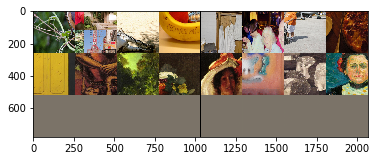

  4%|▍         | 1600/40000 [12:42<5:39:59,  1.88it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_1600.pth


  4%|▍         | 1600/40000 [12:42<5:39:59,  1.88it/s]

printing train images results: (content, style, out)


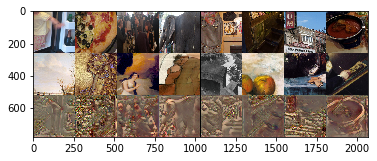

  8%|▊         | 3200/40000 [25:26<3:43:39,  2.74it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_3200.pth


  8%|▊         | 3200/40000 [25:26<3:43:39,  2.74it/s]

printing train images results: (content, style, out)


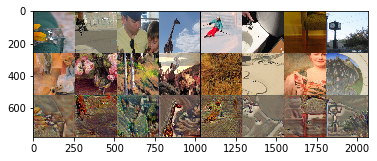

 12%|█▏        | 4800/40000 [38:04<6:11:52,  1.58it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_4800.pth


 12%|█▏        | 4800/40000 [38:08<6:11:52,  1.58it/s]

printing train images results: (content, style, out)


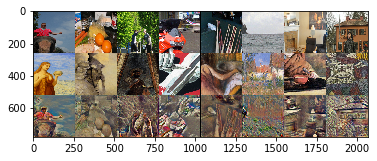

 16%|█▌        | 6400/40000 [50:58<3:23:35,  2.75it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_6400.pth


 16%|█▌        | 6400/40000 [51:01<3:23:35,  2.75it/s]

printing train images results: (content, style, out)


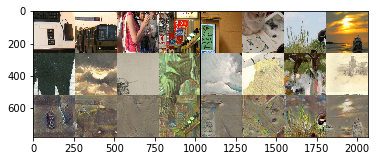

 20%|██        | 8000/40000 [1:03:20<3:08:30,  2.83it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_8000.pth


 20%|██        | 8000/40000 [1:03:23<3:08:30,  2.83it/s]

printing train images results: (content, style, out)


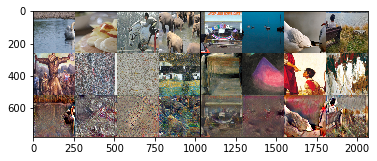

 24%|██▍       | 9600/40000 [1:16:33<3:01:04,  2.80it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_9600.pth


 24%|██▍       | 9600/40000 [1:16:36<3:01:04,  2.80it/s]

printing train images results: (content, style, out)


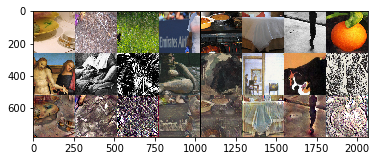

 28%|██▊       | 11200/40000 [1:29:29<3:04:03,  2.61it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_11200.pth


 28%|██▊       | 11200/40000 [1:29:32<3:04:03,  2.61it/s]

printing train images results: (content, style, out)


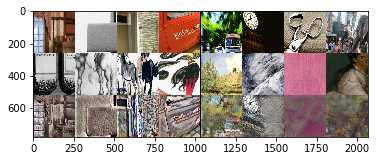

 32%|███▏      | 12800/40000 [1:41:47<2:46:08,  2.73it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_12800.pth


 32%|███▏      | 12800/40000 [1:41:50<2:46:08,  2.73it/s]

printing train images results: (content, style, out)


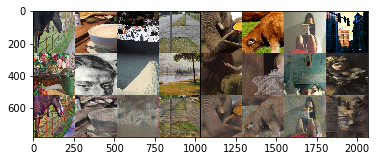

 36%|███▌      | 14400/40000 [1:54:06<2:36:20,  2.73it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_14400.pth


 36%|███▌      | 14400/40000 [1:54:09<2:36:20,  2.73it/s]

printing train images results: (content, style, out)


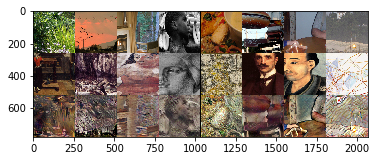

 40%|████      | 16000/40000 [2:07:13<2:24:18,  2.77it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_16000.pth


 40%|████      | 16000/40000 [2:07:16<2:24:18,  2.77it/s]

printing train images results: (content, style, out)


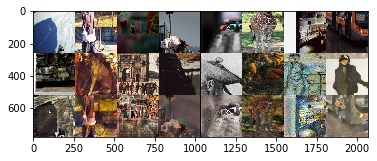

 44%|████▍     | 17600/40000 [2:20:30<2:22:52,  2.61it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_17600.pth


 44%|████▍     | 17600/40000 [2:20:33<2:22:52,  2.61it/s]

printing train images results: (content, style, out)


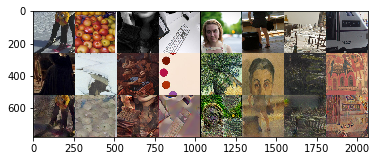

 48%|████▊     | 19200/40000 [2:32:31<2:05:38,  2.76it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_19200.pth


 48%|████▊     | 19200/40000 [2:32:34<2:05:38,  2.76it/s]

printing train images results: (content, style, out)


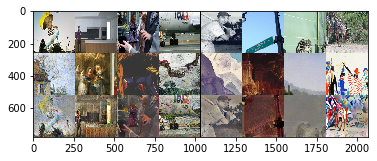

 52%|█████▏    | 20800/40000 [2:45:07<2:10:42,  2.45it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_20800.pth


 52%|█████▏    | 20800/40000 [2:45:10<2:10:42,  2.45it/s]

printing train images results: (content, style, out)


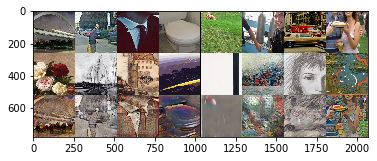

 56%|█████▌    | 22400/40000 [2:57:47<1:47:23,  2.73it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_22400.pth


 56%|█████▌    | 22400/40000 [2:57:49<1:47:23,  2.73it/s]

printing train images results: (content, style, out)


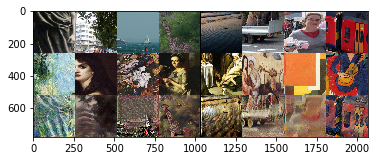

 60%|██████    | 24000/40000 [3:10:45<2:56:22,  1.51it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_24000.pth


 60%|██████    | 24000/40000 [3:10:48<2:56:22,  1.51it/s]

printing train images results: (content, style, out)


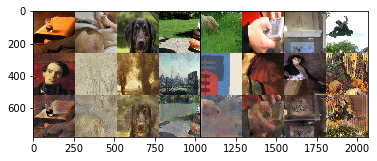

 64%|██████▍   | 25600/40000 [3:23:02<1:42:14,  2.35it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_25600.pth


 64%|██████▍   | 25600/40000 [3:23:05<1:42:14,  2.35it/s]

printing train images results: (content, style, out)


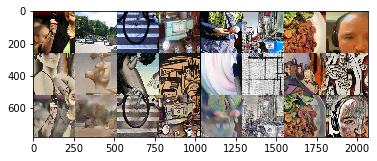

 68%|██████▊   | 27200/40000 [3:36:26<1:19:57,  2.67it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_27200.pth


 68%|██████▊   | 27200/40000 [3:36:28<1:19:57,  2.67it/s]

printing train images results: (content, style, out)


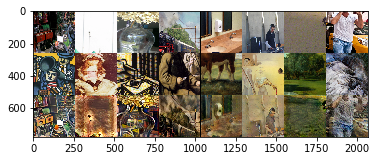

 72%|███████▏  | 28800/40000 [3:49:39<1:16:47,  2.43it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_28800.pth


 72%|███████▏  | 28800/40000 [3:49:42<1:16:47,  2.43it/s]

printing train images results: (content, style, out)


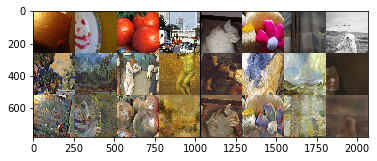

 76%|███████▌  | 30400/40000 [4:02:28<1:01:00,  2.62it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_30400.pth


 76%|███████▌  | 30400/40000 [4:02:30<1:01:00,  2.62it/s]

printing train images results: (content, style, out)


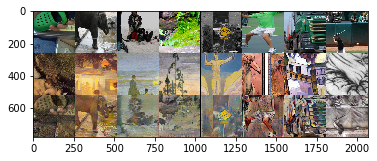

 80%|████████  | 32000/40000 [4:15:45<49:53,  2.67it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_32000.pth


 80%|████████  | 32000/40000 [4:15:48<49:53,  2.67it/s]

printing train images results: (content, style, out)


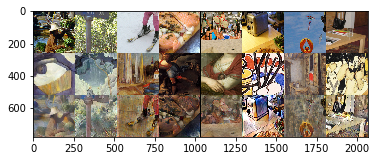

 84%|████████▍ | 33600/40000 [4:28:56<42:41,  2.50it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_33600.pth


 84%|████████▍ | 33600/40000 [4:28:59<42:41,  2.50it/s]

printing train images results: (content, style, out)


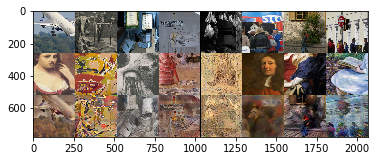

 88%|████████▊ | 35200/40000 [4:41:16<30:02,  2.66it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_35200.pth


 88%|████████▊ | 35200/40000 [4:41:19<30:02,  2.66it/s]

printing train images results: (content, style, out)


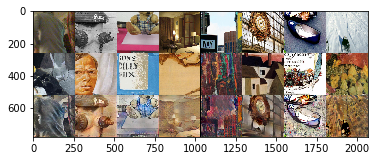

 92%|█████████▏| 36800/40000 [4:54:28<20:40,  2.58it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_36800.pth


 92%|█████████▏| 36800/40000 [4:54:31<20:40,  2.58it/s]

printing train images results: (content, style, out)


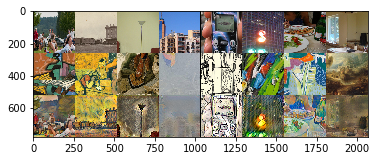

 96%|█████████▌| 38400/40000 [5:07:52<09:57,  2.68it/s]

saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//iter_38400.pth


 96%|█████████▌| 38400/40000 [5:07:55<09:57,  2.68it/s]

printing train images results: (content, style, out)


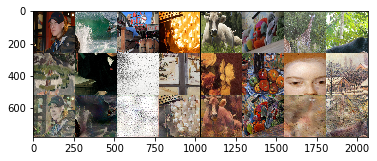

100%|██████████| 40000/40000 [5:20:27<00:00,  2.70it/s]


saving model checkpoint: /gdrive/My Drive/Colab Notebooks/adaptive_style_transfer/models//final_iter_39999.pth


In [12]:
# create network instance
model = style_transfer_net()

if GLOBAL_ARGS['MODE'] == 'train':  
  # train model
  train(model)
elif GLOBAL_ARGS['MODE'] == 'resume_train':
  # resume training
  saved_checkpoint_path=model_save_path + GLOBAL_ARGS['resume_train_from']
  print("loading model from {}".format(saved_checkpoint_path))
  checkpoint = torch.load(saved_checkpoint_path)
  train(model, checkpoint)
elif GLOBAL_ARGS['MODE'] == 'eval':
  saved_checkpoint_path=model_save_path + GLOBAL_ARGS['eval_model_path']
  checkpoint = torch.load(saved_checkpoint_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  model_eval(model)
else:
  assert 0